In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import binned_statistic

from models import CFM
from models import Flow, FlowSubtraction
from models import Classifier
from gaussian_toy import GaussianToy
from plots import plot_naive_unfold, plot_reweighted_distribution, plot_prior_unfold, SetStyle
SetStyle()


# Create Gaussian toy example. Define six datasets:
1. Reco-level simulation
2. Gen-level simulation
3. Background simulation
4. Reco-level data
5. Gen-level data
6. Background data

In [2]:
data_params = { "n_dim": 1,
                "n_mc": 100000,
                "mc_mu": 0,
                "mc_sigma": 1,
                "n_data": 100000,
                "data_mu": 0.2,
                "data_sigma": 0.8,
                "detector_mu": 0,
                "detector_sigma": 0.5,
                "n_background": 10000,
                "background_mu": 0,
                "background_sigma": 1.2,
                "mc_rec_cut": True,
                "mc_gen_cut": True,
                "data_rec_cut": True,
                "data_gen_cut": True ,
                "efficiency": 0.1,
                "acceptance": 0.1,
                "empty_value": -5.0,
}

In [3]:
ToyModel = GaussianToy(data_params)

# Define background subtraction flow

In [4]:
bkg_mc = ToyModel.mc_background_rec

In [5]:
flow_params = { "hidden_layers": 2,
               "internal_size": 64,
               "lr": 1.e-4,
               "n_epochs" : 100,
               "batch_size" : 128,
               "batch_size_sample": 2000}

In [6]:
background_generator = Flow(dims_x = data_params['n_dim'], dims_c = 0,params = flow_params)

In [7]:
background_generator.train(bkg_mc,weights = torch.ones_like(bkg_mc[:,0]))

Training generative model for 100 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.8110771179199219 after time 0.8
    Finished epoch 20 with average loss 1.6111479997634888 after time 9.7
    Finished epoch 40 with average loss 1.597612738609314 after time 18.6
    Finished epoch 60 with average loss 1.5973005294799805 after time 27.5
    Finished epoch 80 with average loss 1.5948843955993652 after time 36.3
    Finished epoch 99 with average loss 1.5990005731582642 after time 44.7


In [8]:
generated_background = background_generator.evaluate(num_evts = ToyModel.mc_background_rec.size(0))

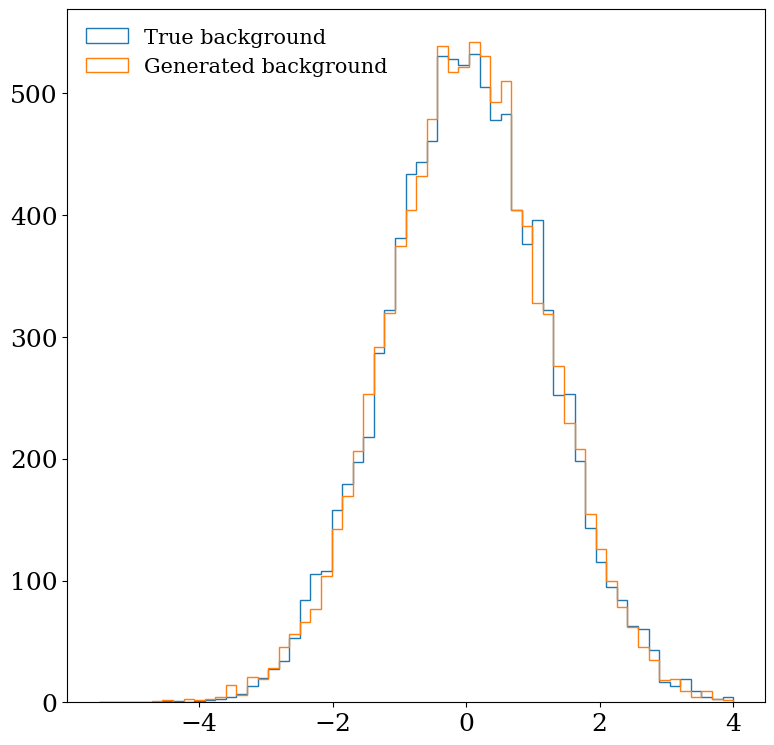

In [9]:
y_true = plt.hist(ToyModel.mc_background_rec[:,0].cpu().detach().numpy(),bins = 60, range = [-5.5,4],label = "True background", histtype='step')
y_gen = plt.hist(generated_background[:,0].cpu().detach().numpy(),bins = 60, range = [-5.5,4],label = "Generated background", histtype='step')
plt.legend()

In [10]:
if not os.path.exists("Plots"):
    os.makedirs("Plots")

with PdfPages(f"Plots/background_generated.pdf") as out:
    plot_reweighted_distribution(out, 
                                 ToyModel.mc_background_rec[:,0].cpu().detach().numpy(),
                                 generated_background[:,0].cpu().detach().numpy(),
                                 np.random.normal(0, 1.0, size=ToyModel.mc_background_rec[:,0].size(0)),
                                 range=[-3,4], labels=[r"true background" , "gaussian", "background generated",], name="x_1")    

/global/u2/v/vmikuni/Full_Generative_Unfolding/plots.py:194: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((y_err / y) ** 2 + (hist_errors[0] / hists[0]) ** 2)


In [11]:
signal_generator = FlowSubtraction(dims_x = data_params['n_dim'], dims_c = 0,params = flow_params,
                                   background_model = background_generator.network,
                                   bkg_fraction = data_params["n_background"]*1.0/(data_params["n_data"] +  data_params["n_background"]))

In [12]:
signal_generator.train(ToyModel.data_rec[ToyModel.data_rec_mask.bool()],weights = torch.ones_like(ToyModel.data_rec[ToyModel.data_rec_mask.bool()][:,0]))

Training generative model for 100 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.3962268829345703 after time 5.4
    Finished epoch 20 with average loss 1.3910545110702515 after time 114.4
    Finished epoch 40 with average loss 1.3910211324691772 after time 224.0
    Finished epoch 60 with average loss 1.3909770250320435 after time 333.1
    Finished epoch 80 with average loss 1.3909190893173218 after time 443.0
    Finished epoch 99 with average loss 1.3909060955047607 after time 547.4


# Generate the signal and generate empty events at reco level

In [13]:
num_data_reco = ToyModel.data_signal_rec[:,0][ToyModel.data_rec_mask[:data_params["n_data"]].bool()].size(0)
generated_signal = signal_generator.evaluate(num_evts = num_data_reco) #N*(1-delta)

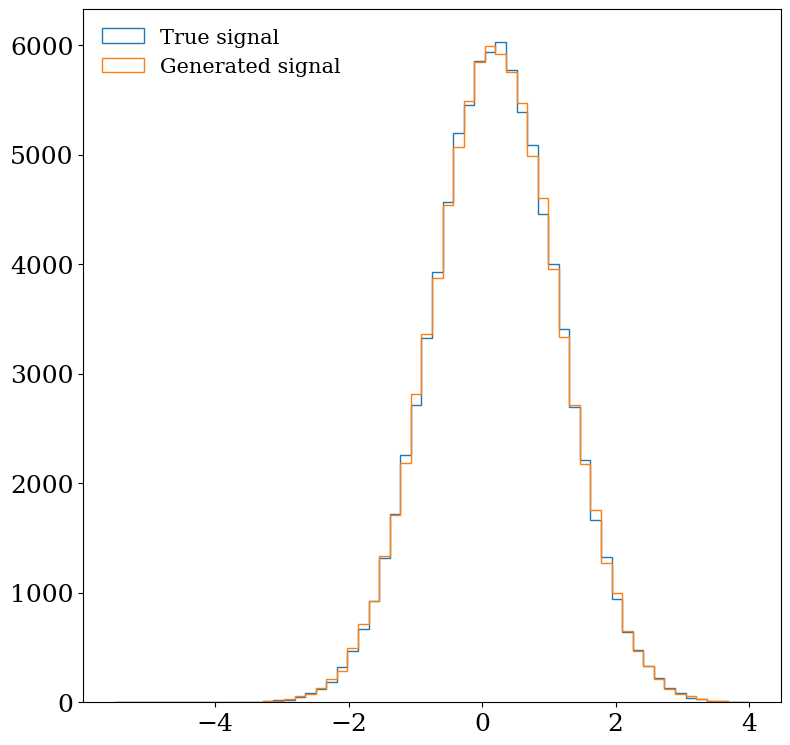

In [14]:
y_true = plt.hist(ToyModel.data_signal_rec[:,0][ToyModel.data_rec_mask[:data_params["n_data"]].bool()].cpu().detach().numpy(),bins = 60, range = [-5.5,4],label = "True signal", histtype='step')
y_gen = plt.hist(generated_signal[:,0].cpu().detach().numpy(),bins = 60, range = [-5.5,4],label = "Generated signal", histtype='step')
plt.legend()

In [15]:
num_data_empty = num_data_reco*data_params['acceptance']/(1.0 - data_params['acceptance']) #N*(1-delta)*epsilon/(1-epsilon)
#Add the empty events to the generated signals
generated_signal = torch.cat([generated_signal,data_params["empty_value"]*torch.ones_like(generated_signal[:int(num_data_empty)])])

In [16]:
print(f"Number of expected signal events in the data {generated_signal.size(0)}")

Number of expected signal events in the data 100110


# Train Acceptance classifier

In [17]:
acceptance_true = ToyModel.mc_rec[(ToyModel.mc_rec_mask.bool()) & (ToyModel.mc_gen_mask.bool())]
acceptance_false = ToyModel.mc_rec[(ToyModel.mc_rec_mask.bool()) & ~(ToyModel.mc_gen_mask.bool())]

In [18]:
acceptance_classifier_params = { "hidden_layers": 4,
                                 "internal_size": 64,
                                 "lr": 1.e-4,
                                 "n_epochs" : 30,
                                 "batch_size" : 128,
                                 "batch_size_sample": 2000
}

In [19]:
acceptance_classifier = Classifier(dims_in=1, params=acceptance_classifier_params)

In [20]:
acceptance_classifier.train_classifier(acceptance_true, acceptance_false, balanced=False)

    Training with unbalanced training set with weight 8.940376106194691
Training classifier for 240 epochs with lr 0.0001
    Finished epoch 0 with average loss 6.732397556304932 after time 0.3
    Finished epoch 48 with average loss 3.244555711746216 after time 15.2
    Finished epoch 96 with average loss 3.2447309494018555 after time 30.1
    Finished epoch 144 with average loss 3.2446932792663574 after time 45.9
    Finished epoch 192 with average loss 3.24448823928833 after time 60.3
    Finished epoch 239 with average loss 3.24444317817688 after time 74.4


# Train efficiency classifier

In [21]:
efficiency_classifier_params = { "hidden_layers": 4,
                                 "internal_size": 64,
                                 "lr": 1.e-4,
                                 "n_epochs" : 30,
                                 "batch_size" : 128,
                                 "batch_size_sample": 2000
}

In [22]:
efficiency_true = ToyModel.mc_gen[(ToyModel.mc_rec_mask.bool()) & (ToyModel.mc_gen_mask.bool())]
efficiency_false = ToyModel.mc_gen[~(ToyModel.mc_rec_mask.bool()) & (ToyModel.mc_gen_mask.bool())]

In [23]:
efficiency_classifier = Classifier(dims_in = 1, params = efficiency_classifier_params)

In [24]:
efficiency_classifier.train_classifier(efficiency_true, efficiency_false, balanced=False)

    Training with unbalanced training set with weight 8.83675923901159
Training classifier for 240 epochs with lr 0.0001
    Finished epoch 0 with average loss 6.653234481811523 after time 0.3
    Finished epoch 48 with average loss 3.234074115753174 after time 15.0
    Finished epoch 96 with average loss 3.23352313041687 after time 29.7
    Finished epoch 144 with average loss 3.2334256172180176 after time 44.3
    Finished epoch 192 with average loss 3.233208179473877 after time 58.9
    Finished epoch 239 with average loss 3.2334954738616943 after time 73.3


# Let's train the detector response flow p(reco|gen) and the initial p(gen) flows

In [25]:
gen_generator = Flow(dims_x = data_params['n_dim'], dims_c = 0,params = flow_params)

In [26]:
gen_generator.train(ToyModel.mc_gen[ToyModel.mc_gen_mask.bool()],weights = torch.ones_like(ToyModel.mc_gen[ToyModel.mc_gen_mask.bool()][:,0]))

Training generative model for 100 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.425236463546753 after time 3.7
    Finished epoch 20 with average loss 1.4181139469146729 after time 77.2
    Finished epoch 40 with average loss 1.4180551767349243 after time 150.8
    Finished epoch 60 with average loss 1.4180222749710083 after time 225.3
    Finished epoch 80 with average loss 1.417931079864502 after time 300.0
    Finished epoch 99 with average loss 1.417928695678711 after time 370.8


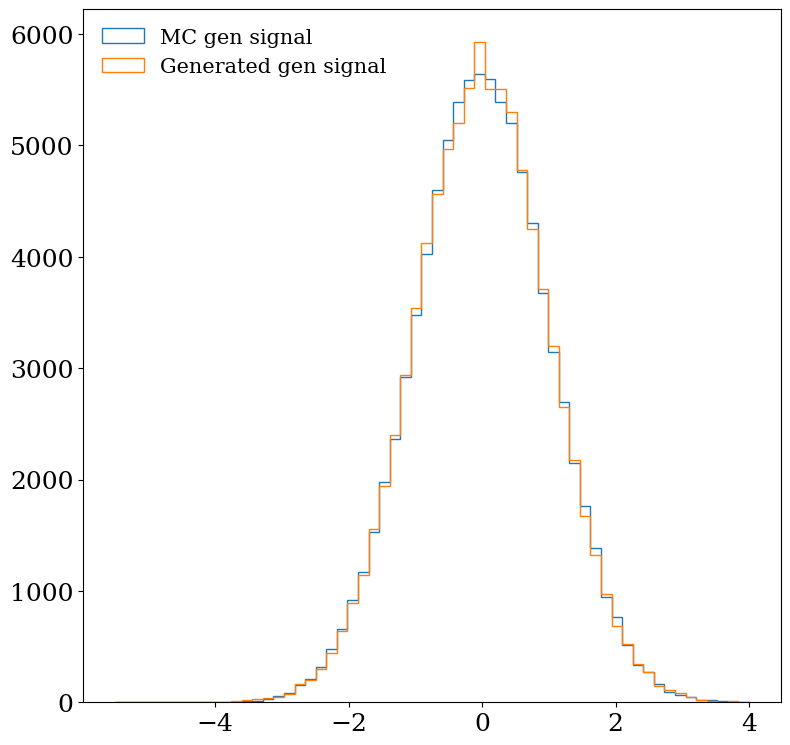

In [27]:
y_true = plt.hist(ToyModel.mc_gen[:,0][ToyModel.mc_gen_mask.bool()].cpu().detach().numpy(),
                  bins = 60, range = [-5.5,4],label = "MC gen signal", histtype='step')
y_gen = plt.hist(gen_generator.evaluate(num_evts = ToyModel.mc_gen[ToyModel.mc_gen_mask.bool()].size(0)).cpu().detach().numpy(),
                 bins = 60, range = [-5.5,4],label = "Generated gen signal", histtype='step')
plt.legend()

In [28]:
detector_generator = Flow(dims_x = data_params['n_dim'], dims_c = data_params['n_dim'],params = flow_params)

In [29]:
detector_generator.train(ToyModel.mc_rec[ToyModel.mc_rec_mask.bool()],
                         weights = torch.ones_like(ToyModel.mc_rec[ToyModel.mc_rec_mask.bool()][:,0]), 
                         data_c = ToyModel.mc_gen[ToyModel.mc_rec_mask.bool()])

using conditional model
Training generative model for 100 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.0121628046035767 after time 4.3
    Finished epoch 20 with average loss 0.8101251721382141 after time 88.9
    Finished epoch 40 with average loss 0.8091316819190979 after time 173.9
    Finished epoch 60 with average loss 0.8082613348960876 after time 257.4
    Finished epoch 80 with average loss 0.8079250454902649 after time 340.7
    Finished epoch 99 with average loss 0.8072099089622498 after time 419.7


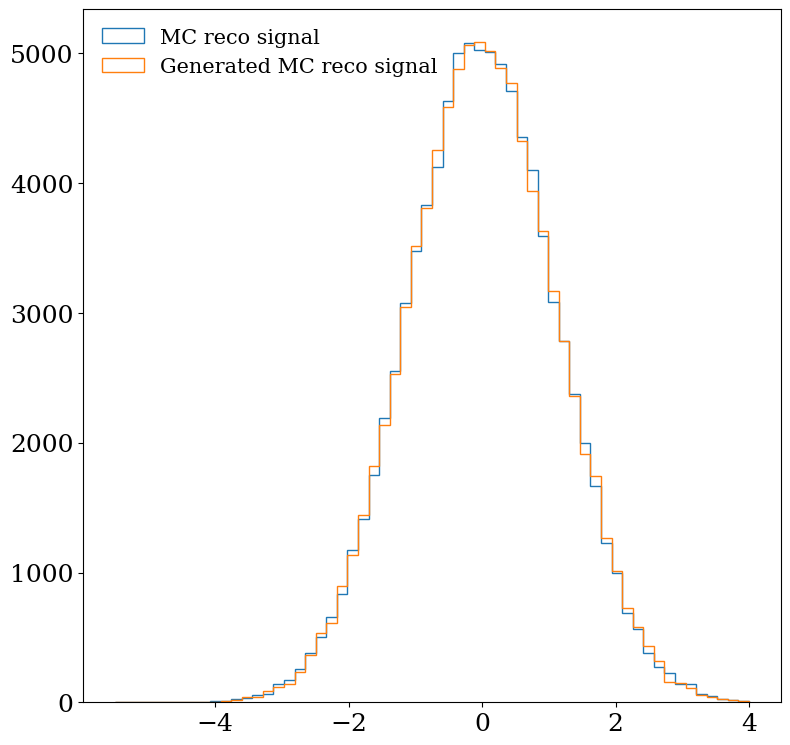

In [30]:
y_true = plt.hist(ToyModel.mc_rec[:,0][ToyModel.mc_rec_mask.bool()].cpu().detach().numpy(),
                  bins = 60, range = [-5.5,4],label = "MC reco signal", histtype='step')
y_gen = plt.hist(detector_generator.evaluate(data_c = ToyModel.mc_gen[ToyModel.mc_rec_mask.bool()]).cpu().detach().numpy(),
                 bins = 60, range = [-5.5,4],label = "Generated MC reco signal", histtype='step')
plt.legend()

# Start the unfolding!

In [31]:
def sample_reco(nevts,empty_fraction, efficiency_classifier,detector_model,gen_model):
    ''' Generates h(reco|gen) samples by sampling from: h(reco|gen) = c(gen) + (1-c(gen))*p(reco|gen)*p(gen) '''
    gen_events = gen_model.evaluate(num_evts = nevts)
    gen_mask = ToyModel.apply_efficiency_acceptance_effects(gen_events,empty_fraction)
    gen_events[~gen_mask.bool()] = data_params["empty_value"]*torch.ones_like(gen_events[~gen_mask.bool()])
    
    efficiency = efficiency_classifier.evaluate(gen_events, return_weights=False)
    sample_efficiency = torch.bernoulli(efficiency)
    
    reco_events = detector_model.evaluate(data_c=gen_events)
    reco_events[~sample_efficiency.bool()] = data_params["empty_value"]*torch.ones_like(gen_events[~sample_efficiency.bool()])
    return  reco_events, gen_events, gen_mask 

In [ ]:
iterations = 5
unfold_generator =  Flow(dims_x = data_params['n_dim'], dims_c = data_params['n_dim'],params = flow_params)
for i in range(iterations):
    print(f"Running iteration {i}")
    reco_train, gen_train, gen_mask = sample_reco(data_params['n_mc'], 
                                                 data_params['efficiency'],
                                                 efficiency_classifier,
                                                 detector_generator,
                                                 gen_generator)
    unfold_generator.train(gen_train[gen_mask.bool()], 
                           weights = torch.ones_like(gen_train[gen_mask.bool()][:,0]), 
                           data_c = reco_train[gen_mask.bool()])
    unfolded = unfold_generator.evaluate(data_c=generated_signal)
    gen_generator.train(unfolded,weights = torch.ones_like(unfolded[:,0]))
    #FIXME: Probably need to update the efficiency classifier here
    fig, axes = plt.subplots()
    axes.hist(unfolded[:,0].cpu().detach().numpy(), bins=60, histtype="step", range=[-5.5,4],label="Gen. Unfolded",density=True)
    axes.hist(ToyModel.mc_gen[:,0][ToyModel.mc_gen_mask.bool()].cpu().detach().numpy(),bins=60, histtype='step', range=[-5.5,4],label="Gen. MC",density=True)
    axes.hist(ToyModel.data_gen[:,0][ToyModel.data_gen_mask.bool()].cpu().detach().numpy(), 
              bins=60, range=[-5.5,4], histtype="step", label="Gen. Truth pass all",density=True)
    plt.legend()  # Display the legend
    plt.show()

Running iteration 0
using conditional model
Training generative model for 100 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.9461506009101868 after time 4.3


# Fix Acceptance with empty true events

In [ ]:
acceptance = acceptance_classifier.evaluate(generated_signal, return_weights=False)
acceptance_mask = torch.bernoulli(acceptance)
unfolded = unfolded[acceptance_mask.bool()]
print(f"Unfolded true events {unfolded.size(0)}, Number of true data events {torch.sum(ToyModel.data_gen_mask.bool())}")

In [ ]:
with PdfPages(f"Plots/final_generative_unfolding.pdf") as out:
    plot_naive_unfold(out, 
                      ToyModel.data_gen[:, 0][ToyModel.data_gen_mask.bool()].cpu().detach().numpy(),
                      ToyModel.data_rec[:, 0][ToyModel.data_rec_mask.bool()].cpu().detach().numpy(),
                      unfolded[:, 0].cpu().detach().numpy(),
                      range=[-3, 4], name="x_1")